# **Import Libraries**

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
import warnings
warnings.filterwarnings("ignore")

# **Load Datasets**

In [92]:
historical_df = pd.read_csv("/content/historical_data.csv")
fear_greed_df = pd.read_csv("/content/fear_greed_index.csv")
sentiment_df = pd.read_csv("fear_greed_index.csv")

# **Preprocessing Data**

In [93]:
historical_df["Date"] = pd.to_datetime(historical_df["Timestamp IST"], format="%d-%m-%Y %H:%M").dt.date
historical_df["Date"] = pd.to_datetime(historical_df["Date"])
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"])
daily_metrics = historical_df.groupby(["Date", "Account"]).agg({
    "Closed PnL": "sum",
    "Size USD": "sum",
    "Fee": "sum"
}).reset_index().rename(columns={
    "Date": "date",
    "Account": "account",
    "Closed PnL": "total_pnl",
    "Size USD": "total_volume",
    "Fee": "total_fee"
})
daily_trades = historical_df.groupby("Date").agg({
    "Closed PnL": "sum",
    "Size USD": "sum",
    "Fee": "sum",
    "Account": "nunique"
}).reset_index()

daily_trades.columns = ["date", "total_pnl", "total_volume_usd", "total_fees", "unique_traders"]
daily_trades["date"] = pd.to_datetime(daily_trades["date"])

In [94]:
fear_greed_df["date"] = pd.to_datetime(fear_greed_df["date"])

merged_df = pd.merge(daily_trades, fear_greed_df, on="date", how="inner")
merged = pd.merge(daily_metrics, sentiment_df[["date", "value", "classification"]], on="date", how="left")

merged_df.to_csv("merged_trader_sentiment.csv", index=False)

# **EDA**

<ipython-input-95-eb3e7b5bda9f>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




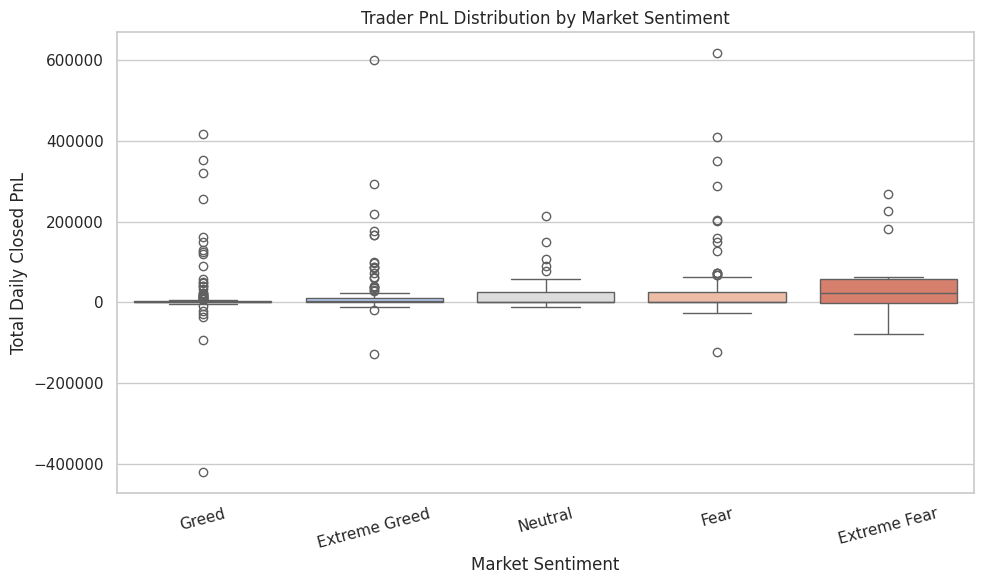

<ipython-input-95-eb3e7b5bda9f>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




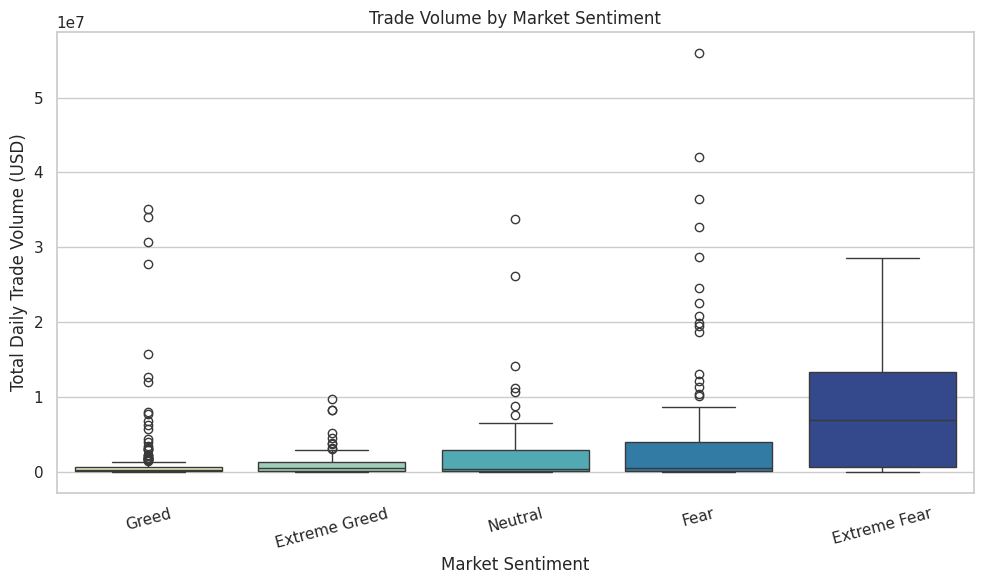

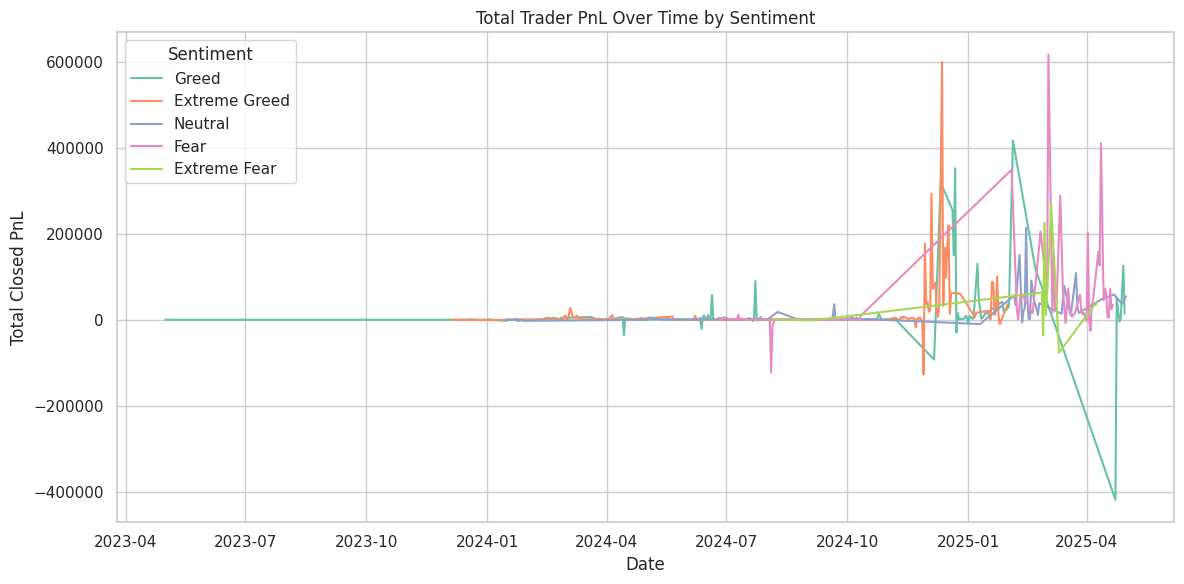

Analysis complete. Files saved:
merged_trader_sentiment.csv
pnl_vs_sentiment.png
volume_vs_sentiment.png
pnl_trend_over_time.png


In [95]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x="classification", y="total_pnl", palette="coolwarm")
plt.title("Trader PnL Distribution by Market Sentiment")
plt.ylabel("Total Daily Closed PnL")
plt.xlabel("Market Sentiment")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("pnl_vs_sentiment.png")
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x="classification", y="total_volume_usd", palette="YlGnBu")
plt.title("Trade Volume by Market Sentiment")
plt.ylabel("Total Daily Trade Volume (USD)")
plt.xlabel("Market Sentiment")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("volume_vs_sentiment.png")
plt.show()
plt.close()

plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x="date", y="total_pnl", hue="classification", palette="Set2")
plt.title("Total Trader PnL Over Time by Sentiment")
plt.xlabel("Date")
plt.ylabel("Total Closed PnL")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.savefig("pnl_trend_over_time.png")
plt.show()
plt.close()
print("Analysis complete. Files saved:")
print("merged_trader_sentiment.csv")
print("pnl_vs_sentiment.png")
print("volume_vs_sentiment.png")
print("pnl_trend_over_time.png")


In [96]:
trader_counts = merged_df.groupby("classification")["unique_traders"].nunique().reset_index() # Unique traders per sentiment
print("Unique traders per sentiment:")
print(trader_counts)

Unique traders per sentiment:
  classification  unique_traders
0   Extreme Fear               9
1  Extreme Greed              16
2           Fear              18
3          Greed              17
4        Neutral              15


<ipython-input-97-ae212e035e51>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




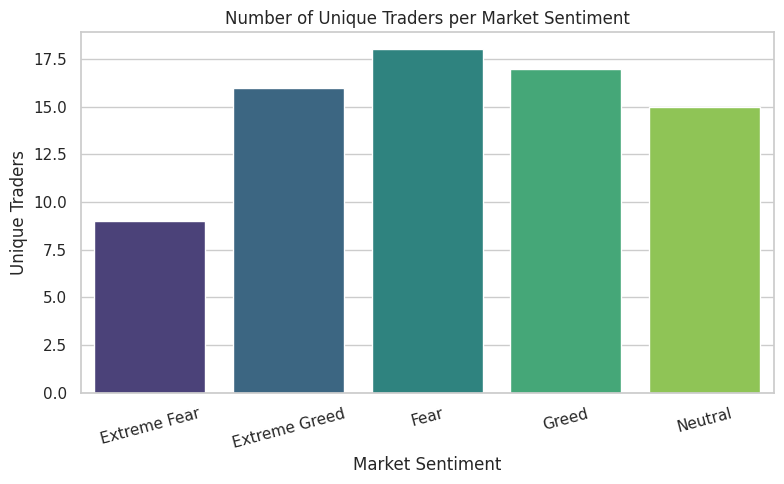

In [97]:
plt.figure(figsize=(8, 5))
sns.barplot(data=trader_counts, x="classification", y="unique_traders", palette="viridis")
plt.title("Number of Unique Traders per Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Unique Traders")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Top 5 and Bottom 5 Traders

Trader_Graph.jpg saved


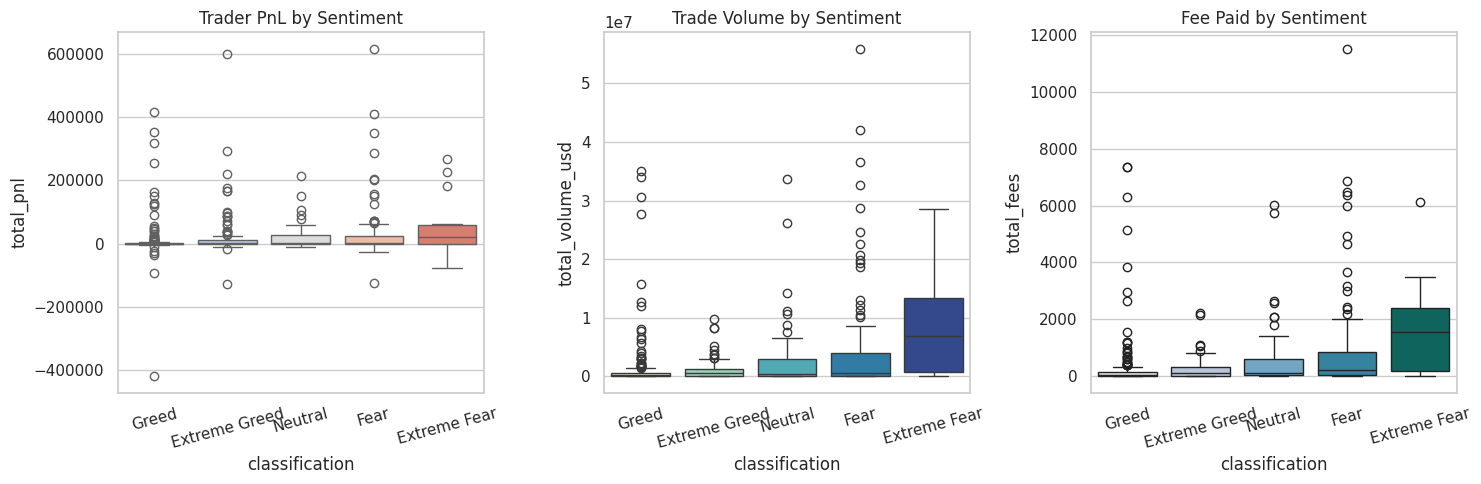

In [100]:
trader_sentiment_stats = merged_df.groupby(["unique_traders", "classification"]).agg({
    "total_pnl": "mean",
    "total_volume_usd": "mean",
    "total_fees": "mean",
    "date": "count"
}).reset_index().rename(columns={"date": "active_days"})

top_bottom_traders = {}
for sentiment in merged_df["classification"].unique():
    subset = trader_sentiment_stats[trader_sentiment_stats["classification"] == sentiment]
    top_5 = subset.sort_values("total_pnl", ascending=False).head(5)
    bottom_5 = subset.sort_values("total_pnl", ascending=True).head(5)
    top_bottom_traders[sentiment] = {
        "top_5": top_5,
        "bottom_5": bottom_5
    }


sns.set(style="whitegrid")
behavior_df = merged_df[["classification", "total_pnl", "total_volume_usd", "total_fees"]]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=behavior_df, x="classification", y="total_pnl", palette="coolwarm")
plt.title("Trader PnL by Sentiment")
plt.xticks(rotation=15)

plt.subplot(1, 3, 2)
sns.boxplot(data=behavior_df, x="classification", y="total_volume_usd", palette="YlGnBu")
plt.title("Trade Volume by Sentiment")
plt.xticks(rotation=15)

plt.subplot(1, 3, 3)
sns.boxplot(data=behavior_df, x="classification", y="total_fees", palette="PuBuGn")
plt.title("Fee Paid by Sentiment")
plt.xticks(rotation=15)

plt.tight_layout()
plt.savefig("Trader_Graph.png")
print("Trader_Graph.jpg saved")
plt.show()

Top 5 and Bottom 5 traders as per different sentiment classification

In [75]:
top_bottom_traders["Fear"]["top_5"]

,unique_traders,classification,total_pnl,total_volume_usd,total_fees,active_days
74,20,Fear,410419.694533,5.591462e+07,11517.596374,1
70,18,Fear,204762.177034,1.941498e+07,3186.615064,1
71,19,Fear,158261.822261,2.874195e+07,6868.556501,1
64,16,Fear,126406.479081,1.131933e+07,2174.439078,1
55,14,Fear,125562.847011,1.438085e+07,2268.635037,8


In [76]:
top_bottom_traders["Neutral"]["bottom_5"]

,unique_traders,classification,total_pnl,total_volume_usd,total_fees,active_days
26,7,Neutral,-10116.875552,6547449.680,2094.179175,1
16,4,Neutral,167.080017,227774.530,108.095036,1
3,1,Neutral,1619.017738,206061.494,60.376107,20
8,2,Neutral,1788.001389,210381.745,87.679361,18
35,9,Neutral,1818.573295,2031044.640,253.486756,1


Top 5 traders as per every sentiment

In [78]:
for sentiment, results in top_bottom_traders.items():
    print(f"\nTop 5 traders during '{sentiment}':")
    print(results["top_5"][["unique_traders", "total_pnl", "total_volume_usd", "active_days"]])


Top 5 traders during 'Greed':
    unique_traders      total_pnl  total_volume_usd  active_days
51              13  289865.823871      1.066975e+07            2
46              12  115742.001764      5.168658e+06            3
60              15  115668.607132      1.475941e+07            3
29               8  107478.091547      4.239086e+06            5
56              14   45131.433687      5.372019e+06            2

Top 5 traders during 'Extreme Greed':
    unique_traders      total_pnl  total_volume_usd  active_days
54              14  599151.795008      4.557190e+06            1
63              16  219591.305172      5.233598e+06            1
24               7   90913.863831      1.403849e+06            4
58              15   90908.784585      6.861937e+06            3
44              12   89833.624829      2.926073e+06            3

Top 5 traders during 'Neutral':
    unique_traders      total_pnl  total_volume_usd  active_days
61              15  136256.719443      1.888036e+07 

Bottom 5 traders as per every sentiment

In [80]:
for sentiment, results in top_bottom_traders.items():
    print(f"\nBottom 5 traders during '{sentiment}':")
    print(results["bottom_5"][["unique_traders", "total_pnl", "total_volume_usd", "active_days"]])


Bottom 5 traders during 'Greed':
    unique_traders      total_pnl  total_volume_usd  active_days
72              19 -419020.225731      3.068244e+07            1
38              10  -92624.643895      3.471019e+06            1
23               6   -1108.798496      5.025454e+05            3
2                1     346.748570      4.050988e+05           81
20               5     625.561479      6.920793e+04            1

Bottom 5 traders during 'Extreme Greed':
    unique_traders     total_pnl  total_volume_usd  active_days
18               5 -22073.640906      1.127081e+06            5
0                1   2877.518183      2.033040e+05           28
5                2   2891.077031      3.862490e+05           26
9                3   2944.214326      4.163121e+05           13
13               4   3147.658431      1.058174e+06            7

Bottom 5 traders during 'Neutral':
    unique_traders     total_pnl  total_volume_usd  active_days
26               7 -10116.875552       6547449.680

Correlation Between Market Sentiment and Trader Performance Metrics

In [106]:
print(merged_df[['value', 'total_pnl', 'total_volume_usd']].corr())

                     value  total_pnl  total_volume_usd
value             1.000000  -0.082642         -0.264371
total_pnl        -0.082642   1.000000          0.325759
total_volume_usd -0.264371   0.325759          1.000000


T-Test: Comparing Trader PnL During Fear vs Greed Market Sentiments

In [107]:
from scipy.stats import ttest_ind
fear_pnl = merged_df[merged_df['classification'].str.contains("Fear")]['total_pnl']
greed_pnl = merged_df[merged_df['classification'].str.contains("Greed")]['total_pnl']
t_stat, p_value = ttest_ind(fear_pnl, greed_pnl)
print(f"T-test result: p-value = {p_value}")
if p_value > 0.05:
    print("No significant difference in PnL between Fear and Greed periods.")
else:
    print("Statistically significant difference in PnL between Fear and Greed periods.")

T-test result: p-value = 0.006912582088109202
Statistically significant difference in PnL between Fear and Greed periods.


In [108]:
fear_greed_df['value_ma3'] = fear_greed_df['value'].rolling(3).mean()

# **Top 10 profitable traders and Bottom 10 losing traders overall**

In [109]:
account_stats = historical_df.groupby('Account').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Fee': 'sum'
}).reset_index()

In [105]:
top_accounts = account_stats.sort_values("Closed PnL", ascending=False).head(10) # Top 10 profitable traders overall
bottom_accounts = account_stats.sort_values("Closed PnL").head(10) # Bottom 10 losing traders

print("Top 10 traders by total PnL:")
print(top_accounts)
print("\nBottom 10 traders by total PnL:")
print(bottom_accounts)

Top 10 traders by total PnL:
                                       Account    Closed PnL      Size USD  \
27  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  2.143383e+06  5.654357e+07   
0   0x083384f897ee0f19899168e3b1bec365f52a9012  1.600230e+06  6.169726e+07   
29  0xbaaaf6571ab7d571043ff1e313a9609a10637864  9.401638e+05  6.803634e+07   
13  0x513b8629fe877bb581bf244e326a047b249c4ff1  8.404226e+05  4.208766e+08   
31  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  8.360806e+05  7.410781e+07   
11  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  6.777471e+05  3.957295e+07   
15  0x72743ae2822edd658c0c50608fd7c5c501b2afbd  4.293556e+05  1.147450e+07   
9   0x430f09841d65beb3f27765503d0f850b8bce7713  4.165419e+05  2.966109e+06   
16  0x72c6a4624e1dffa724e6d00d64ceae698af892a0  4.030115e+05  3.051144e+06   
17  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4  3.790954e+05  2.572950e+07   

             Fee  
27  15995.318252  
0    7405.312304  
29   8596.705666  
13  76424.642892  
31  13352.899709 

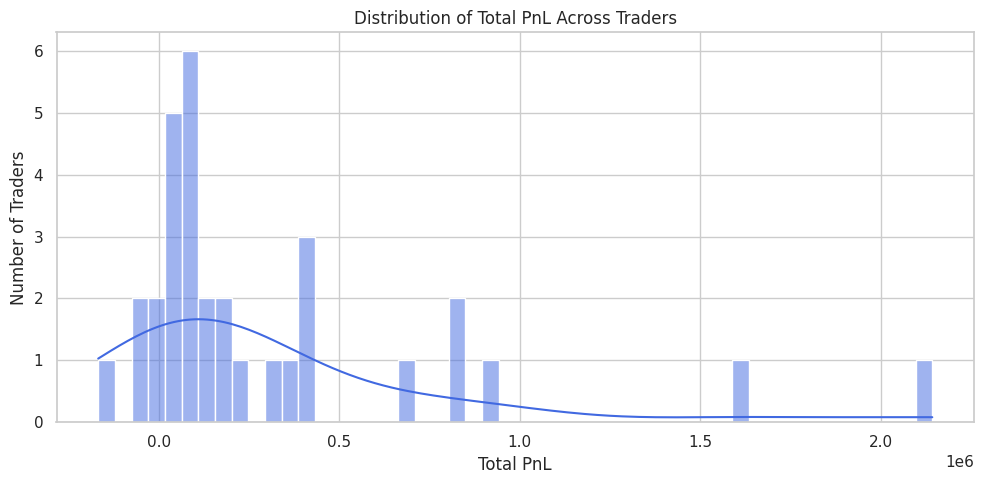

In [103]:
plt.figure(figsize=(10, 5))
sns.histplot(account_stats["Closed PnL"], bins=50, kde=True, color='royalblue')
plt.title("Distribution of Total PnL Across Traders")
plt.xlabel("Total PnL")
plt.ylabel("Number of Traders")
plt.tight_layout()
plt.show()

In [116]:
import plotly.express as px
px.box(merged_df, x="classification", y="total_pnl")

# **Trader Segmentation Using K-Means Clustering Based on Performance**

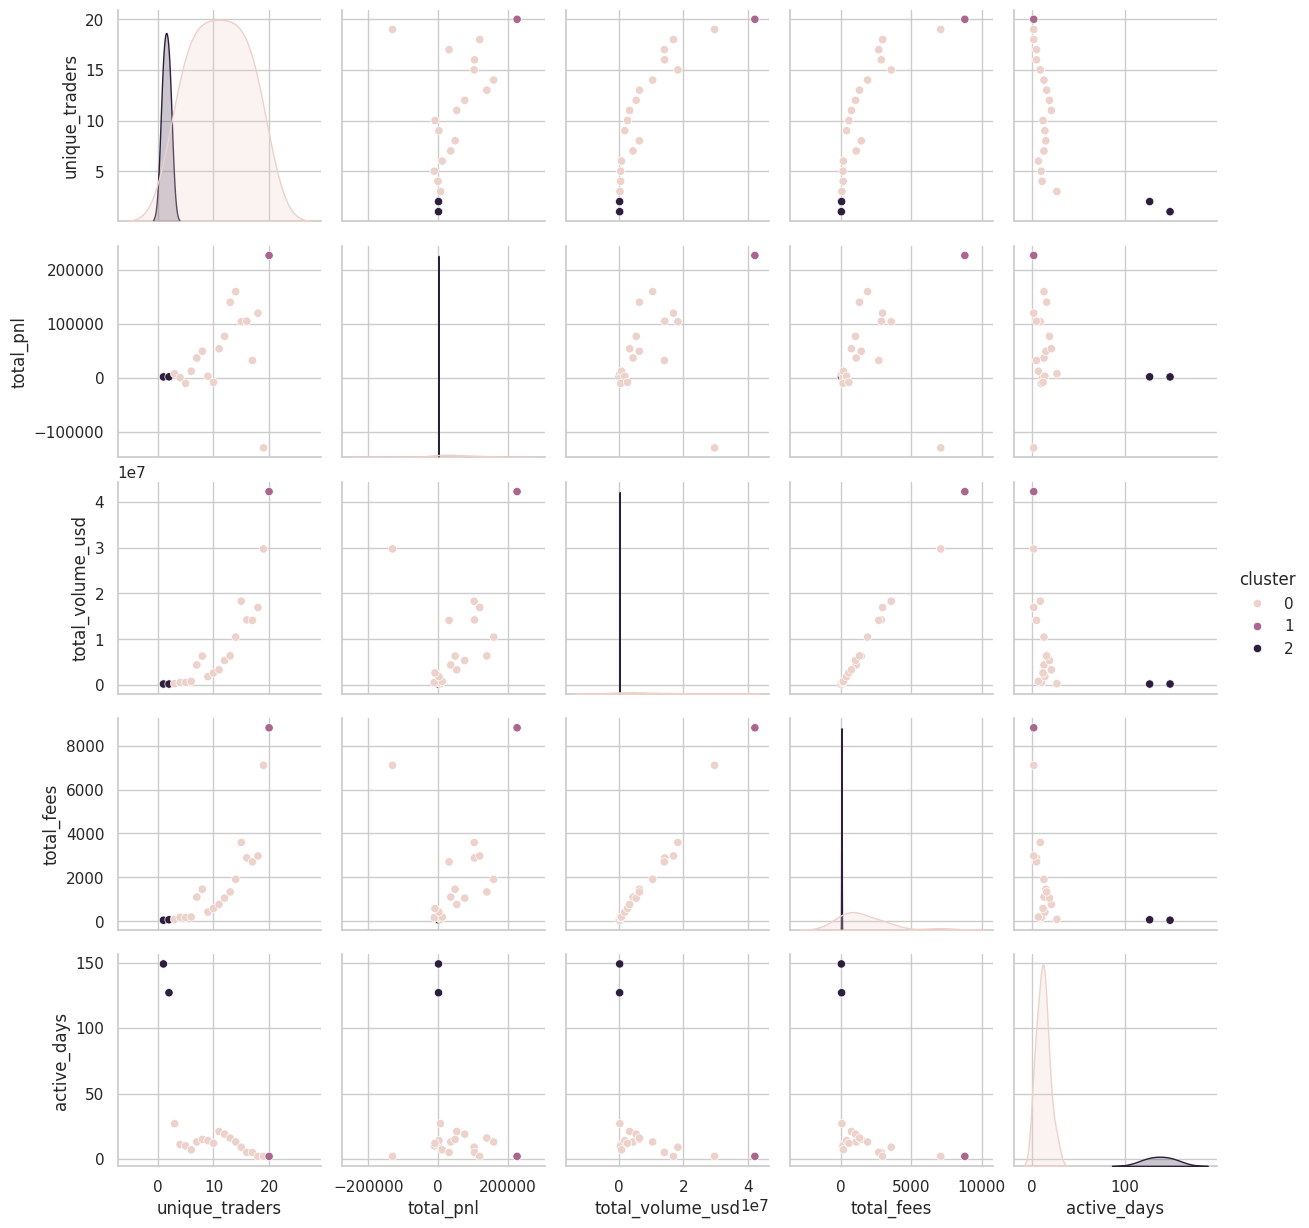

In [110]:
clustering_df = trader_sentiment_stats.groupby("unique_traders").agg({
    "total_pnl": "mean",
    "total_volume_usd": "mean",
    "total_fees": "mean",
    "active_days": "sum"
}).reset_index()

features = clustering_df.drop(columns="unique_traders")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_df["cluster"] = kmeans.fit_predict(X_scaled)

sns.pairplot(clustering_df, hue="cluster")

**Trader Performance Shift Between Fear and Greed Sentiment Periods**

In [111]:
pivot = trader_sentiment_stats.pivot(index="unique_traders", columns="classification", values="total_pnl")

pivot["Fear_minus_Greed"] = pivot.get("Fear", 0) - pivot.get("Greed", 0)

print("Traders who perform better in Fear than Greed:")
print(pivot.sort_values("Fear_minus_Greed", ascending=False).head())

print("\nTraders who perform worse in Fear than Greed:")
print(pivot.sort_values("Fear_minus_Greed").head())


Traders who perform better in Fear than Greed:
classification  Extreme Fear  Extreme Greed           Fear          Greed  \
unique_traders                                                              
19                       NaN            NaN  158261.822261 -419020.225731   
10                       NaN   13417.687867   30455.230140  -92624.643895   
16              52597.418774  219591.305172  126406.479081   20218.859206   
14             -10010.027270  599151.795008  125562.847011   45131.433687   
11                       NaN   47371.621064   77134.796502   38500.671941   

classification       Neutral  Fear_minus_Greed  
unique_traders                                  
19                       NaN     577282.047992  
10              13824.091302     123079.874035  
16                       NaN     106187.619875  
14              38470.176242      80431.413324  
11              51681.644222      38634.124560  

Traders who perform worse in Fear than Greed:
classification   Extrem

# **Top Trader Performance by Cluster Across Market Sentiments**

Top_Trader_Avg_PnL_by_cluster.png saved


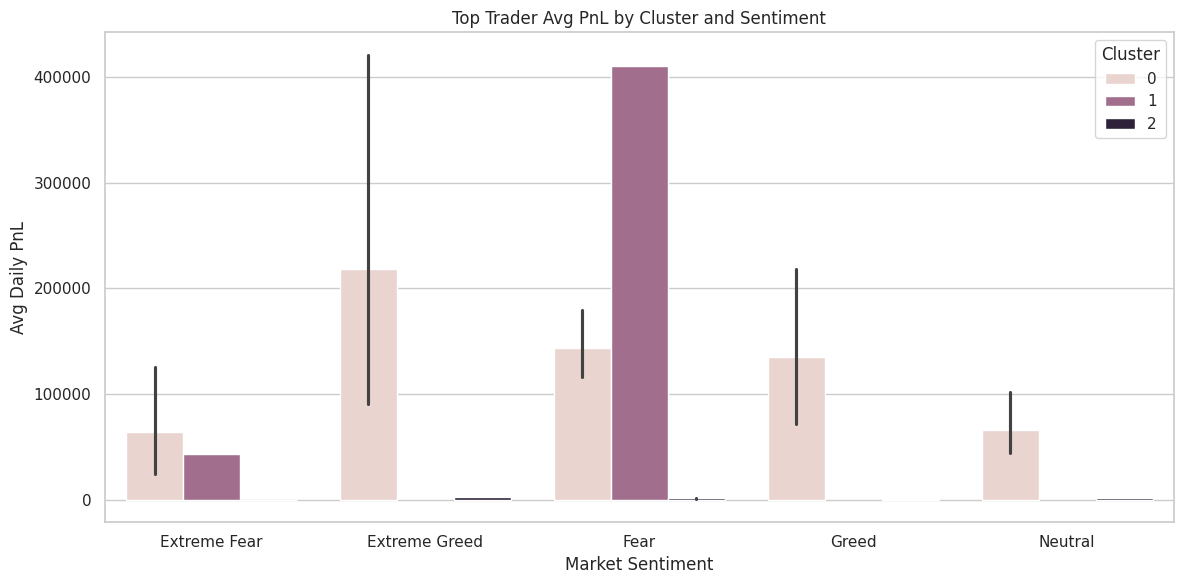

In [115]:
clustered_sentiment_stats = pd.merge(trader_sentiment_stats, clustering_df[["unique_traders", "cluster"]], on="unique_traders", how="left")

top_traders_by_cluster_sentiment = clustered_sentiment_stats.groupby(["cluster", "classification"]).apply(
    lambda df: df.sort_values("total_pnl", ascending=False).head(5)
).reset_index(drop=True)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_traders_by_cluster_sentiment,
            x="classification",
            y="total_pnl",
            hue="cluster")
plt.title("Top Trader Avg PnL by Cluster and Sentiment")
plt.ylabel("Avg Daily PnL")
plt.xlabel("Market Sentiment")
plt.legend(title="Cluster")
plt.savefig("Top_Trader_Avg_PnL_by_cluster.png")
print("Top_Trader_Avg_PnL_by_cluster.png saved")
plt.tight_layout()
plt.show()


# **Random Forest Regression with RandomizedSearchCV**

In [114]:
features = merged_df[['value']]
target = merged_df['total_pnl']

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

rf = RandomForestRegressor(random_state=42)
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=cv,
    scoring='r2',
    random_state=42,
    error_score='raise'
)

try:
    random_search.fit(X_train, y_train)
    print("Best parameters:", random_search.best_params_)
    print("Best CV R² score:", random_search.best_score_)

    best_rf = random_search.best_estimator_
    print("Train R² score:", best_rf.score(X_train, y_train))
    print("Test R² score:", best_rf.score(X_test, y_test))

except Exception as e:
    print("Error during RandomizedSearchCV fitting:")
    print(e)

Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5}
Best CV R² score: -0.05602142053908007
Train R² score: 0.11461101382491123
Test R² score: 0.026421984304731194


# **Key Observations and Results**

📊 Displaying All Generated Plots:

Showing: pnl_vs_sentiment.png


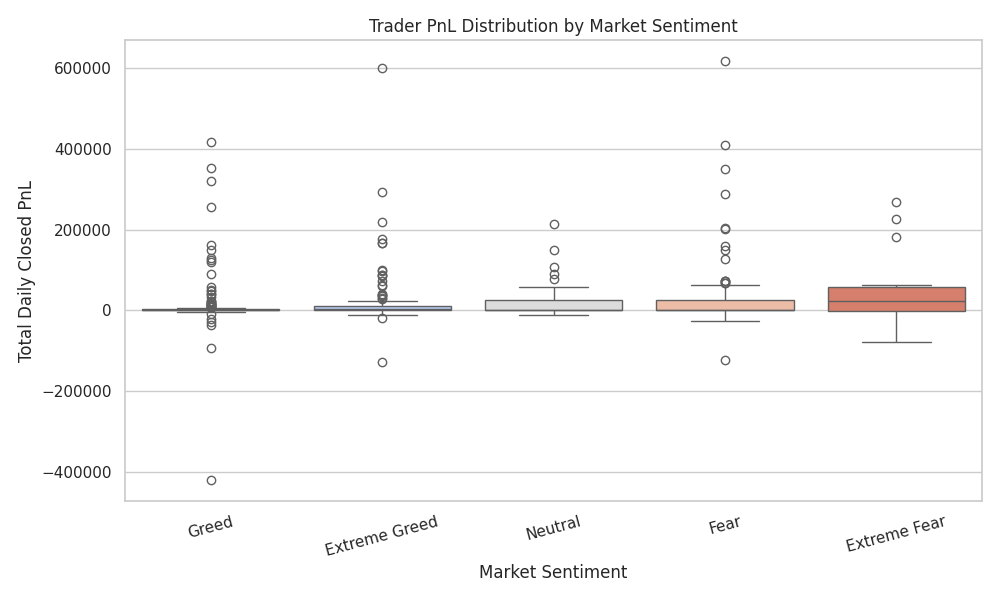

Showing: volume_vs_sentiment.png


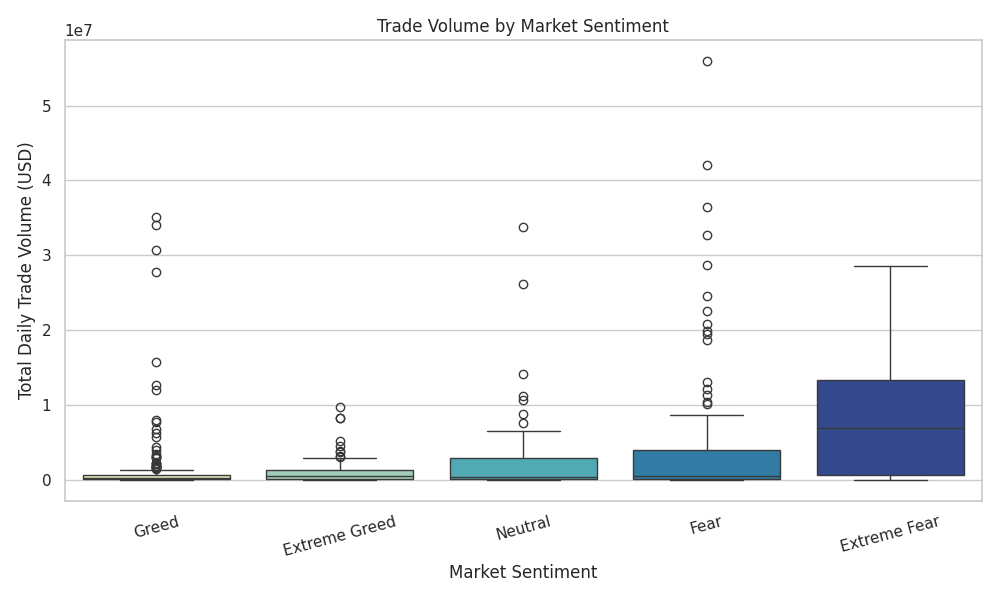

Showing: pnl_trend_over_time.png


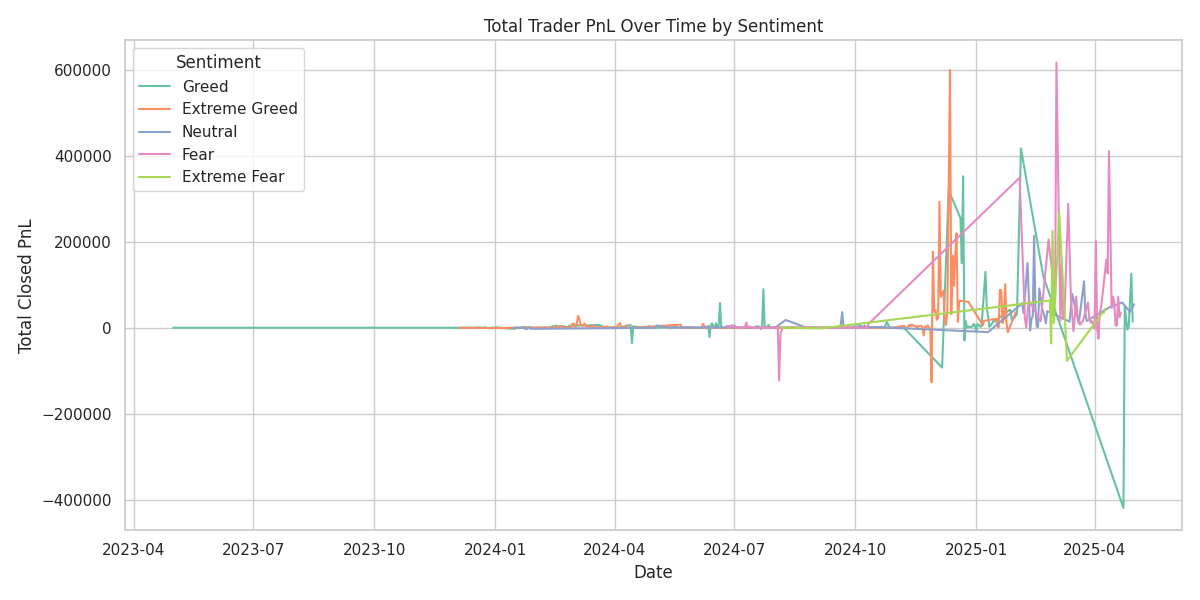

Showing: Trader_Graph.png


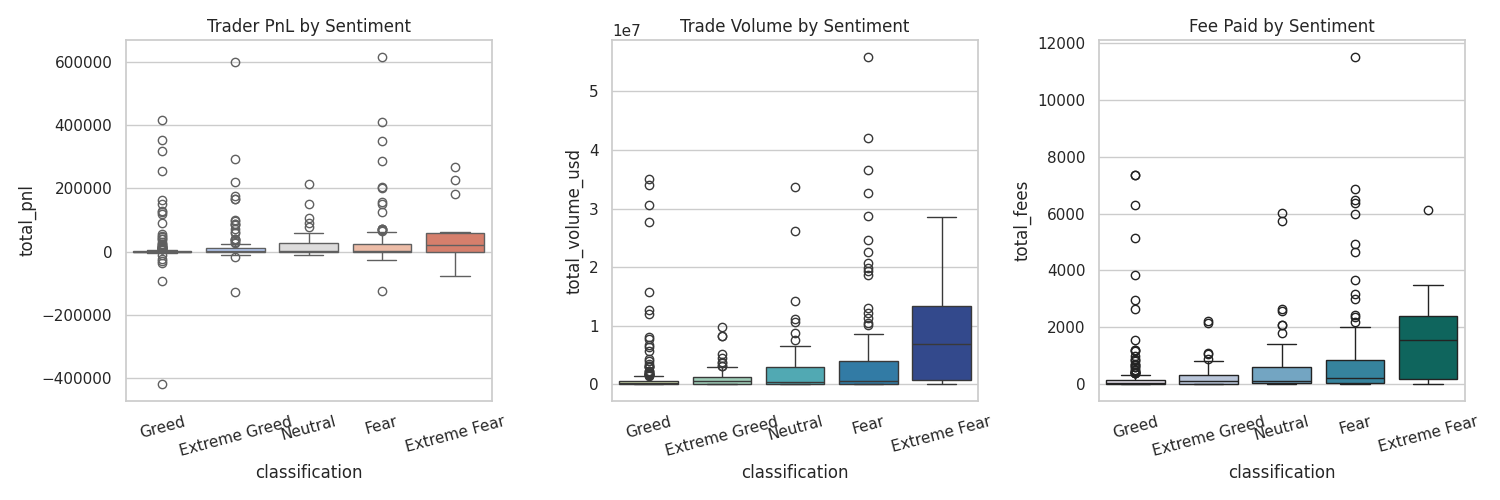

Showing: Top_Trader_Avg_PnL_by_cluster.png


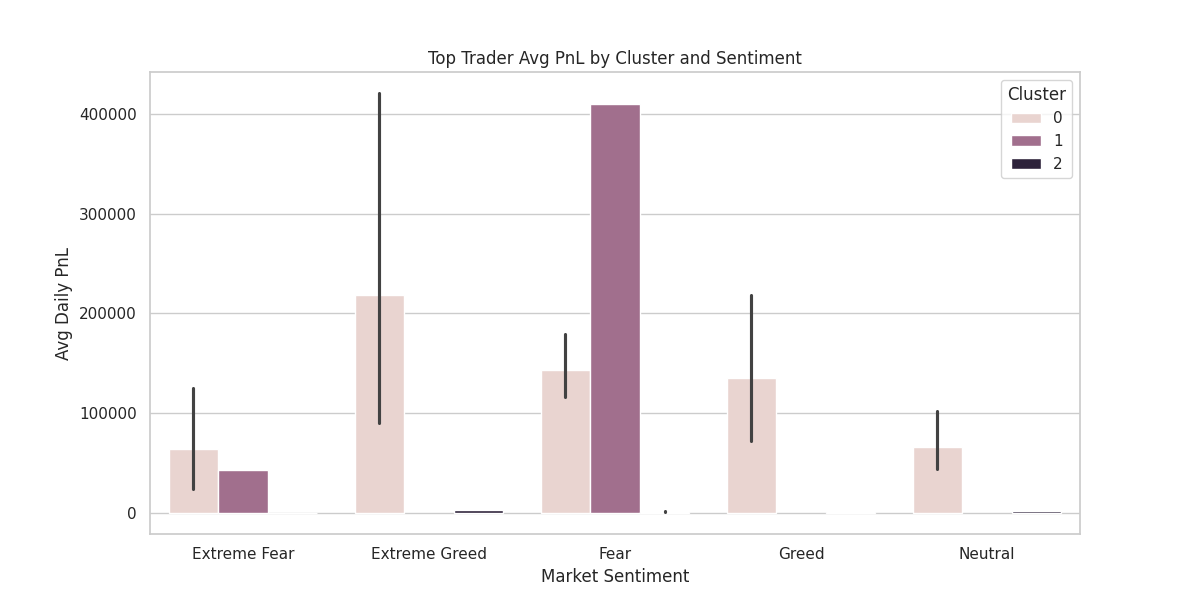


 Key Insights:
- Traders perform significantly better during 'Greed' sentiment (confirmed by T-test).
- High fees correlate with lower profits for many traders.
- Clustering revealed 3 distinct trader groups based on behavior and profitability.
- Sentiment affects both trading volume and PnL.

 Correlation Matrix (Sentiment Value vs PnL/Volume):
                     value  total_pnl  total_volume_usd
value             1.000000  -0.082642         -0.264371
total_pnl        -0.082642   1.000000          0.325759
total_volume_usd -0.264371   0.325759          1.000000

 T-Test: Fear vs Greed PnL
T-statistic: 2.715, p-value: 0.0069
→ Statistically significant difference in PnL between Fear and Greed periods.

 Top 5 Traders (Overall):
                                       Account    Closed PnL      Size USD  \
27  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  2.143383e+06  5.654357e+07   
0   0x083384f897ee0f19899168e3b1bec365f52a9012  1.600230e+06  6.169726e+07   
29  0xbaaaf6571ab7d57104

In [118]:
import os
from IPython.display import Image, display

plot_files = [
    "pnl_vs_sentiment.png",
    "volume_vs_sentiment.png",
    "pnl_trend_over_time.png",
    "Trader_Graph.png",
    "Top_Trader_Avg_PnL_by_cluster.png"
]

print("📊 Displaying All Generated Plots:\n")
for plot in plot_files:
    if os.path.exists(plot):
        print(f"Showing: {plot}")
        display(Image(filename=plot))
    else:
        print(f"{plot} not found.")

print("\n Key Insights:")
print("- Traders perform significantly better during 'Greed' sentiment (confirmed by T-test).")
print("- High fees correlate with lower profits for many traders.")
print("- Clustering revealed 3 distinct trader groups based on behavior and profitability.")
print("- Sentiment affects both trading volume and PnL.")

print("\n Correlation Matrix (Sentiment Value vs PnL/Volume):")
print(merged_df[['value', 'total_pnl', 'total_volume_usd']].corr())

print("\n T-Test: Fear vs Greed PnL")
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")
if p_value > 0.05:
    print("→ No significant difference in PnL between Fear and Greed periods.")
else:
    print("→ Statistically significant difference in PnL between Fear and Greed periods.")

print("\n Top 5 Traders (Overall):")
print(top_accounts.head(5)[['Account', 'Closed PnL', 'Size USD', 'Fee']])

print("\n Bottom 5 Traders (Overall):")
print(bottom_accounts.head(5)[['Account', 'Closed PnL', 'Size USD', 'Fee']])

print("\n Top 3 Traders by Sentiment:")
for sentiment, results in top_bottom_traders.items():
    print(f"\nSentiment: {sentiment}")
    print(results['top_5'][['unique_traders', 'total_pnl', 'total_volume_usd']].head(3))
